In [1]:
#necesary imports

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Couldn't import dot_parser, loading of dot files will not be possible.


This First example creates a surrogate model using besos native Latin Hypercube Sampling considering 40 samples of expensive runs and implements the 3 basic surrogate models, a Gaussian Process, a Neural Network and Finally a TensorFlow model in order to be compared with another similar surrogate model implemented with adaptive sampling with 40 samples for the same IDF and EPW files 

In [2]:
building = ef.get_building("lab_building.idf")
epw_file='Torino_IT-hour.epw'

In [3]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,15.800034,7.221598,58.167466,98690.003995,306.913584,...,99999.0,9.0,999999999.0,17.553311,0.174258,0.001826,74.213014,0.200115,0.082500,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,7.638139,7.427315,13.753316,291.739324,391.724168,...,0.0,0.0,0.0,9.051735,0.060578,0.042701,26.073199,0.002380,0.592314,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,-0.800000,-12.900000,27.000000,97687.000000,0.000000,...,99999.0,9.0,999999999.0,4.000000,0.039000,0.000000,0.000000,0.200000,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,9.700000,1.100000,47.000000,98469.000000,0.000000,...,99999.0,9.0,999999999.0,10.000000,0.126000,0.000000,76.000000,0.200000,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,15.700000,7.400000,57.000000,98731.000000,18.000000,...,99999.0,9.0,999999999.0,16.000000,0.181000,0.000000,88.000000,0.200000,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,22.000000,13.200000,68.000000,98909.250000,590.000000,...,99999.0,9.0,999999999.0,23.000000,0.218000,0.000000,88.000000,0.200000,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,34.300000,25.700000,100.000000,99260.000000,1229.000000,...,99999.0,9.0,999999999.0,56.000000,0.338000,1.000000,88.000000,0.266000,14.000000,99.0


Parameter selection: where search space is defined, this depends on each individual IDF, this is where user selects the design parameters 
he wants to optimize

In [6]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='MW Glass Wool (rolls)_.1445',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='EPS Expanded Polystyrene (Heavyweight)_.1', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)


insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [7]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [8]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=5,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [9]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 30, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [10]:
windows = FieldSelector(class_name='FenestrationSurface:Detailed', 
                        object_name='*',
                        field_name='Construction Name')

win_arr = ['single_glazing','double_glazing','triple_glazing']
windowsTypes = CategoryParameter(win_arr)

windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, 
                                           value_descriptors = windowsTypes, 
                                           name='Windows types'))


Problem statement: This is where we join the features and objectives of the optimization problem, and save them in an EnergyPlus problem

In [11]:
parameters = insulation_param + windowsParameters + [lights_param] + ventilationAchParam + setpointParams 

In [12]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Windows types',
 'Lights Watts/Area',
 'Ventilation ACH',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [13]:
samples_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=60) #Creates 60 samples to be evaluated with EnergyPlus

In [14]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

#Object that initialices the EnergyPlus execution Environment

In [15]:
t1 = time.time()
# Run Energyplus
sim_samples = evaluator.df_apply(samples_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/60 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

In [16]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  8 min 29 seconds


In [17]:
sim_samples.to_pickle("simulation_samples_example_6_60.pkl") #saving the EP runs input - output rows(could save you a lot of time)

here we start the visualization of the data, how inputs and outputs are distributed

In [18]:
sim_samples.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,6.000000e+01,6.000000e+01
mean,0.299677,0.450083,12.507994,2.999554,24.003310,164.824259,8.129472e+09,8.927878e+09,7.720060e+09
std,0.116251,0.203668,4.380782,1.749641,3.491158,78.593658,1.532184e+09,8.562787e+08,1.554831e+09
min,0.103187,0.110165,5.001730,0.078148,18.198902,32.129496,5.497367e+09,7.666211e+09,5.323164e+09
25%,0.200904,0.280732,8.757489,1.543130,21.113214,97.993088,6.803104e+09,8.380396e+09,6.567385e+09
50%,0.300345,0.449608,12.532792,2.973364,23.968741,163.970934,8.100566e+09,8.740811e+09,7.627218e+09
75%,0.397042,0.624882,16.284493,4.454258,26.958437,229.938087,9.496126e+09,9.315467e+09,8.492259e+09
max,0.497591,0.798448,19.937609,5.960408,29.902488,296.233286,1.065152e+10,1.188793e+10,1.274497e+10


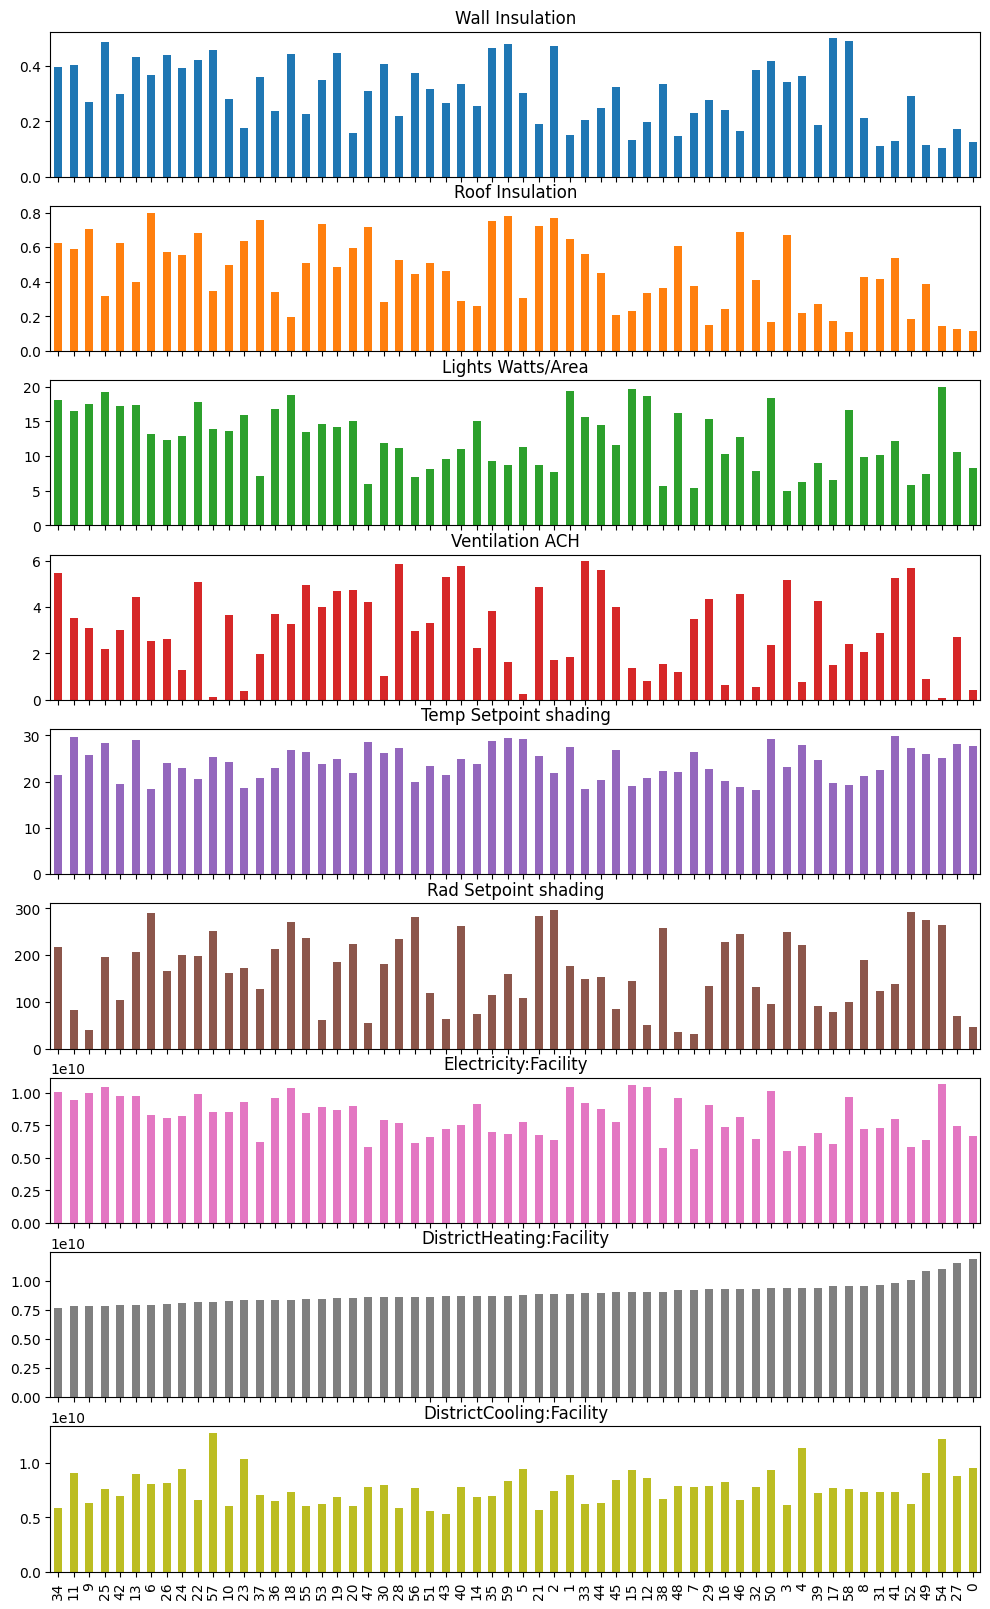

In [19]:
sim_samples = sim_samples.sort_values(by=objectives[1])
ax=sim_samples.plot.bar(subplots=True,legend=None, figsize=(12,20))

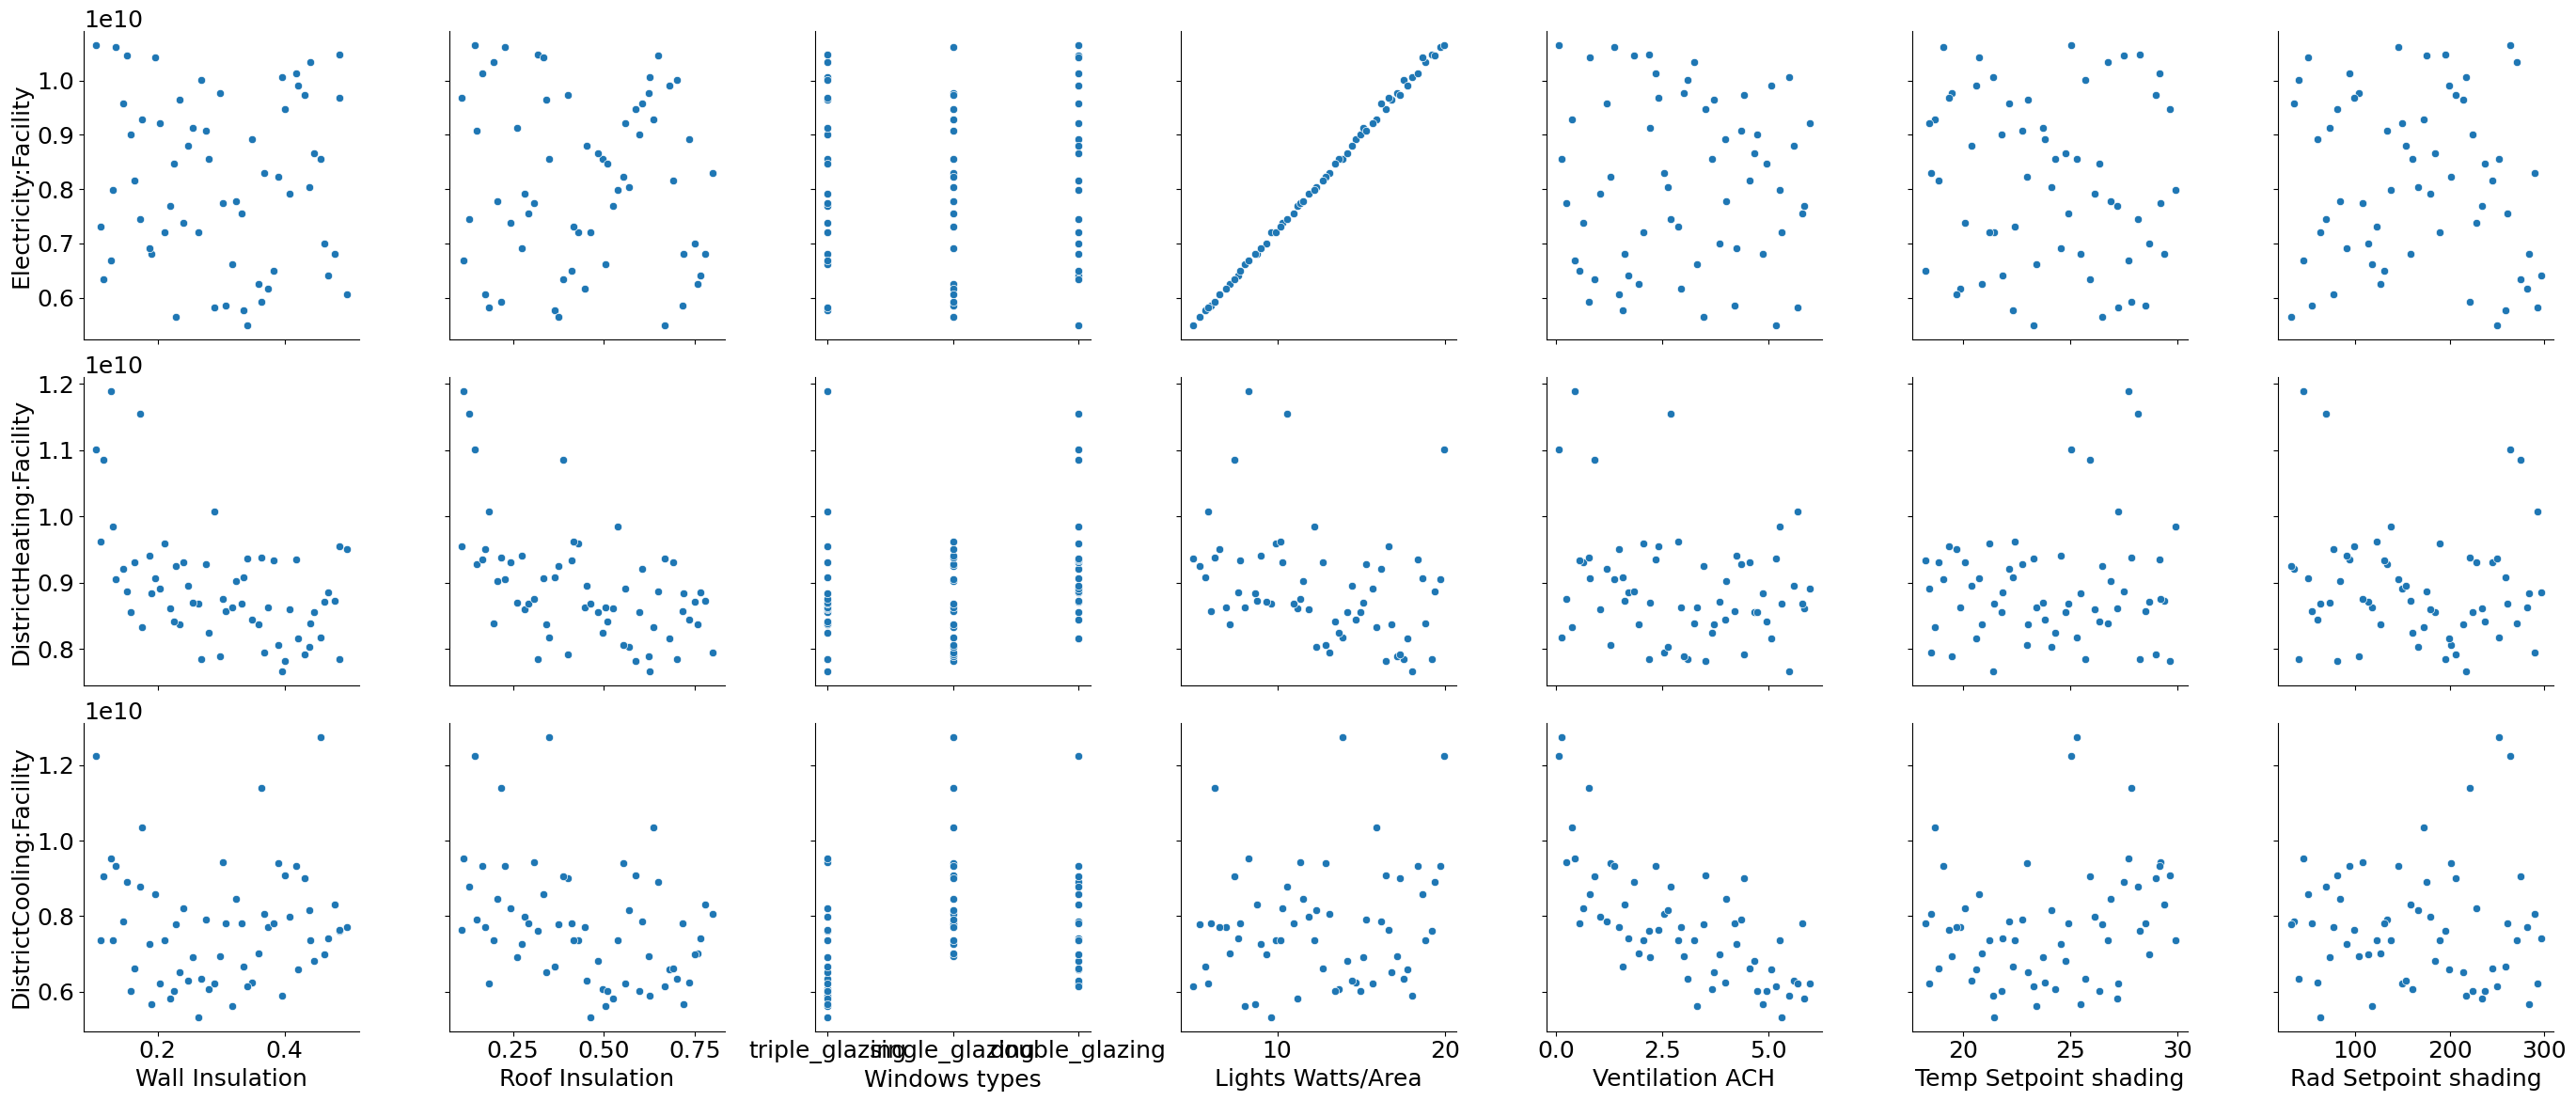

In [20]:
plt.rcParams.update({'font.size': 18})
_=pairplot(sim_samples,x_vars=samples_df.columns, y_vars=objectives, kind="scatter",height=4)

Here we start the correlation analysis, to see hou much the inputs will influece the outputs 

In [22]:
new_samples=sim_samples.drop(['Windows types'], axis=1)

corr=new_samples.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,0.085220,-0.051842,-0.022598,0.085631,0.105953,-0.055180,-0.497818,0.006239
Roof Insulation,0.085220,1.000000,-0.053370,0.263706,-0.139807,0.097737,-0.056244,-0.523910,-0.376853
Lights Watts/Area,-0.051842,-0.053370,1.000000,-0.002230,-0.071926,-0.079164,0.999476,-0.322429,0.147127
Ventilation ACH,-0.022598,0.263706,-0.002230,1.000000,0.055235,0.096959,-0.005010,-0.238129,-0.707846
Temp Setpoint shading,0.085631,-0.139807,-0.071926,0.055235,1.000000,-0.102131,-0.078369,0.125129,0.229010
Rad Setpoint shading,0.105953,0.097737,-0.079164,0.096959,-0.102131,1.000000,-0.094361,-0.099293,0.018697
Electricity:Facility,-0.055180,-0.056244,0.999476,-0.005010,-0.078369,-0.094361,1.000000,-0.322093,0.135752
DistrictHeating:Facility,-0.497818,-0.523910,-0.322429,-0.238129,0.125129,-0.099293,-0.322093,1.000000,0.267601
DistrictCooling:Facility,0.006239,-0.376853,0.147127,-0.707846,0.229010,0.018697,0.135752,0.267601,1.000000


In [23]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.055180,-0.056244,0.999476,-0.005010,-0.078369,-0.094361
DistrictHeating:Facility,-0.497818,-0.523910,-0.322429,-0.238129,0.125129,-0.099293
DistrictCooling:Facility,0.006239,-0.376853,0.147127,-0.707846,0.229010,0.018697


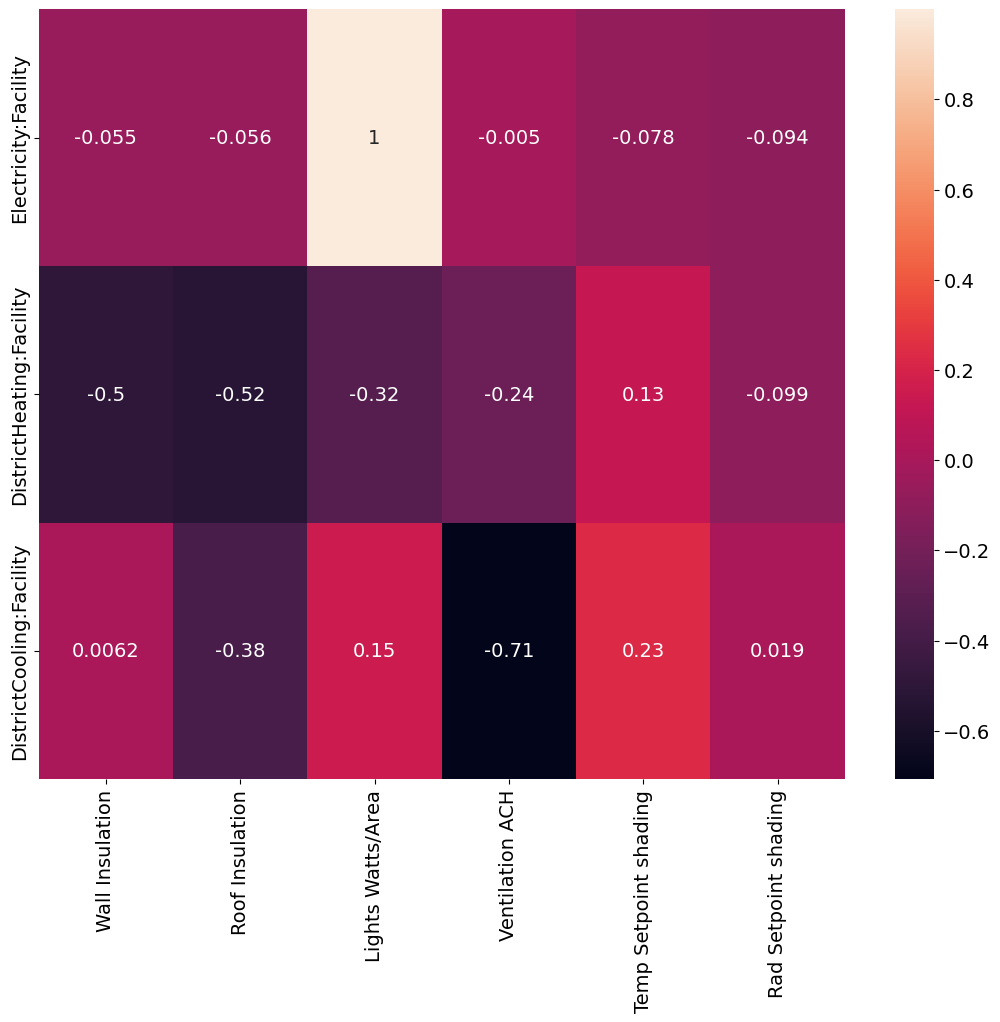

In [24]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

Training process: here we start the training and testing of the models in order to compare them, in this case the 60 samples are separeted in to train
and test sets.

In [25]:
features = list(samples_df.columns)
print(features)
print(objectives)

['Wall Insulation', 'Roof Insulation', 'Windows types', 'Lights Watts/Area', 'Ventilation ACH', 'Temp Setpoint shading', 'Rad Setpoint shading']
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [26]:
outputs = sim_samples.drop(features, axis=1)

In [34]:
samples = sim_samples.drop(objectives, axis=1)

for i,win in enumerate(win_arr):
    samples['Windows types'] = samples['Windows types'].replace(win,i+1)

In [35]:
samples

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
34,0.395879,0.626100,3,18.026671,5.481994,21.396185,217.456806
11,0.400531,0.587867,1,16.492885,3.519742,29.645064,81.688451
9,0.269047,0.702144,3,17.562252,3.106442,25.695008,40.242929
25,0.486312,0.318851,3,19.207810,2.187673,28.247523,195.616293
42,0.298520,0.624475,1,17.158574,3.000256,19.474154,104.093114
13,0.431405,0.399981,1,17.309870,4.419908,28.978963,206.269043
6,0.367518,0.798448,1,13.112782,2.546753,18.474206,290.164264
26,0.439391,0.569654,1,12.341888,2.637029,24.132802,166.870868
24,0.390076,0.552731,1,12.886195,1.286127,22.960348,201.162321
22,0.421042,0.680656,2,17.781382,5.068193,20.576152,199.121326


In [38]:
train_in, test_in, train_out, test_out = train_test_split(
    samples, outputs, test_size=0.2
) #data set in to train and test

In [39]:
#normalizing inputs to remove correlation between inputs
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [40]:
#tarining and testing the Gaussian Processes Regression model

hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [41]:
#tarining and testing the neural network

hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [42]:
#tarining and testing the tensor flow model

def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,547 (17.76 KB)

 Trainable params: 4,547 (17.76 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Here we start with the models performance comparison using the test inputs, predicting the outputs and comparing them with the real outputs

In [43]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100

print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [1.56208669e+08 4.59569638e+08 7.48268024e+08]
RMSE %: [2.01109438 4.93394679 9.58723261]


In [44]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN
RMSE NN: [1.82843317e+08 4.71668386e+08 6.47086037e+08]
RMSE % NN: [2.35399974 5.06383914 8.29083184]


In [45]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF
RMSE TensorFlow: [2.49311938e+08 5.25653511e+08 7.22582094e+08]
RMSE % TensorFlow: [3.209744   5.64342428 9.25812997]


In [48]:
win_arr=[1,2,3]
windowsTypes = CategoryParameter(win_arr)

windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', object_name = fenestration.Name, field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, value_descriptors = windowsTypes, name='Windows types'))

here we start the optimization process

In [51]:
parameters = insulation_param + windowsParameters + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

problem=Problem(parameters, objectives)

In [55]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(best_gp.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)



srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)

for i,win in enumerate(win_arr):
    srinputs['Windows types'] = srinputs['Windows types'].replace(win,i+1)

sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.283122,0.245763,2,18.735712,1.260315,29.517722,124.916138,1.028226e+10,9.538906e+09,1.038468e+10
1,0.132945,0.543451,1,15.857886,0.159343,26.276706,59.892502,9.362574e+09,9.540091e+09,1.104128e+10
2,0.327942,0.237754,3,7.534039,4.388218,22.684606,191.024067,6.351370e+09,9.528052e+09,5.426034e+09
3,0.496323,0.604477,2,15.076901,2.418959,27.839679,255.930745,9.050900e+09,8.367113e+09,8.591754e+09
4,0.479225,0.485879,2,14.381675,5.680263,24.025262,99.558839,8.502555e+09,8.868284e+09,6.905113e+09


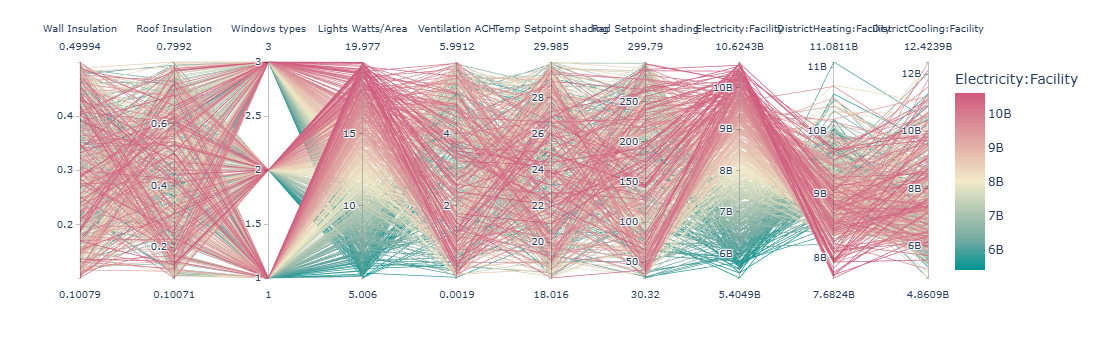

In [56]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [57]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

AttributeError: 'CategoryParameter' object has no attribute 'min'

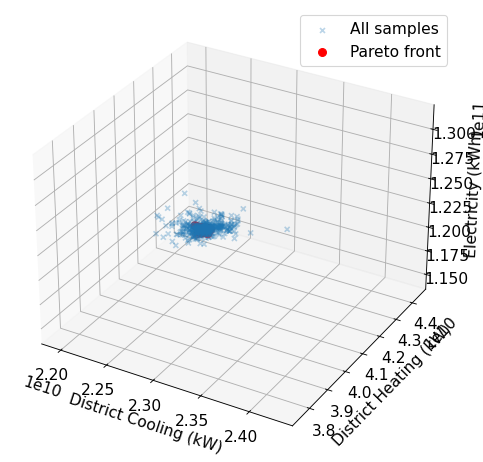

In [50]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [51]:
opt_df

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.195963,0.504441,14.705662,0.952674,24.913359,240.545958,1.232364e+11,4.013480e+10,2.290197e+10
1,0.131345,0.491885,8.563808,2.610487,29.123865,166.052756,1.232301e+11,4.014025e+10,2.290154e+10
2,0.498110,0.753135,13.186459,0.951354,24.731070,191.005664,1.232361e+11,4.013489e+10,2.290194e+10
3,0.400678,0.701760,19.904091,4.450154,29.841172,297.977201,1.232365e+11,4.013475e+10,2.290198e+10
4,0.291141,0.577673,16.776314,5.741755,25.988154,284.198705,1.232365e+11,4.013476e+10,2.290197e+10
...,...,...,...,...,...,...,...,...,...
9995,0.413364,0.291289,12.178353,1.703955,24.898084,81.782784,1.232367e+11,4.013464e+10,2.290199e+10
9996,0.171806,0.135664,12.629587,4.954924,25.505194,106.592839,1.232373e+11,4.013440e+10,2.290199e+10
9997,0.211119,0.259346,14.455450,0.884271,20.379015,278.726633,1.232364e+11,4.013479e+10,2.290197e+10
9998,0.304353,0.604666,16.719282,0.697137,19.002733,137.813121,1.232365e+11,4.013476e+10,2.290197e+10


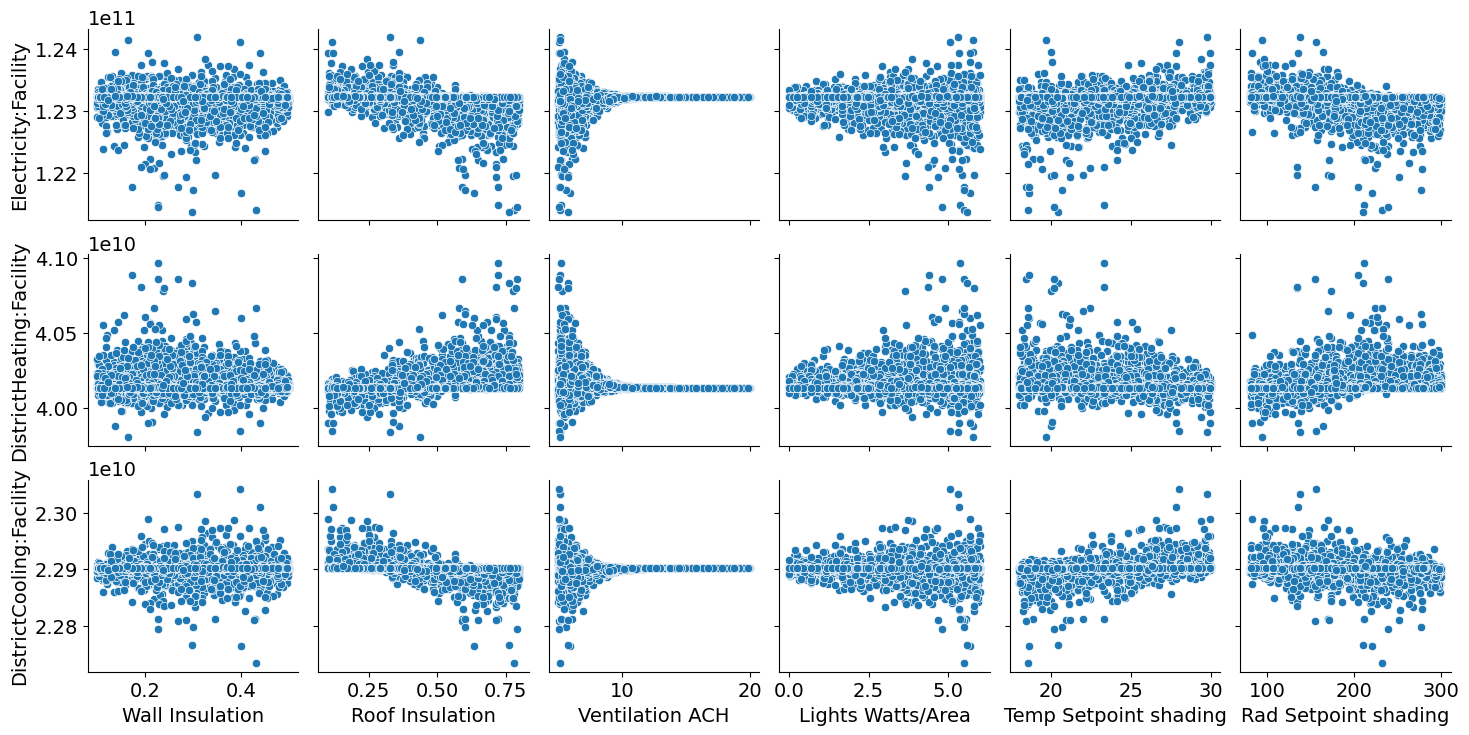

In [52]:
_=pairplot(opt_df,x_vars=samples_df.columns, y_vars=objectives, kind="scatter")

In [53]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [54]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.018866,-0.230530,0.290981,-0.085565,0.125453,-0.178832
DistrictHeating:Facility,-0.037037,0.225204,-0.316590,0.086278,-0.101586,0.147264
DistrictCooling:Facility,0.013889,-0.293685,0.089360,-0.055944,0.194238,-0.097369


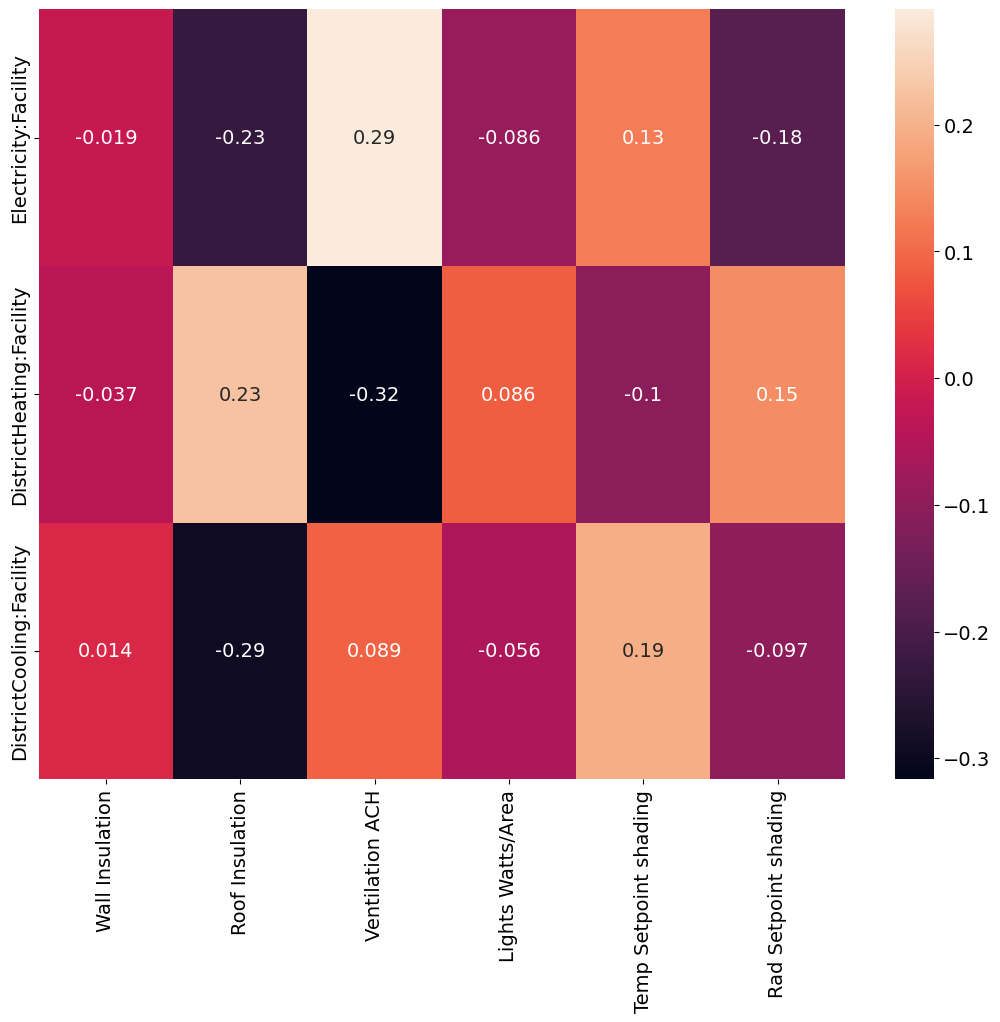

In [55]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [56]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
5856,0.432453,0.781879,5.136693,5.478316,18.518211,232.40138,1.214081e+11,4.066471e+10,2.273380e+10,1.848066e+11,1.300399e+11


In [57]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.4324533571429161,
 'Roof Insulation': 0.7818789894421915,
 'Ventilation ACH': 5.136693026914233,
 'Lights Watts/Area': 5.478316125225762,
 'Temp Setpoint shading': 18.518211071469953,
 'Rad Setpoint shading': 232.40137967140774}